In [4]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18, z_at_value
from astropy.constants import c
from scipy.ndimage.filters import gaussian_filter
import astropy.units as u
import hankl
from scipy import interpolate
from scipy.integrate import quadrature
from scipy.special import jv
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from sympy.physics.wigner import wigner_3j
from scipy.integrate import quadrature

%matplotlib inline

/var/folders/l0/bsqsn6_s01b0hvjnf7bv_wdw0000gn/T/ipykernel_94986/3140175382.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


# Calculate $C_l^{\Delta g}(r_1, r_2)$

In [5]:
sigma = 0.1 # Standard deviation of the fiducial dndz
z_mean = 0.6 # Central redshift of the fiducial dndz

# Set the range for the integrals over r. If this changes, the normalization of phi(r) will need to be changed too
z_min_int = 0.005
z_max_int = z_mean+2

# Now characterize the perturbations to the dndz
sigma_zshift = z_mean/5. # Standard deviation of the shifts in the central redshift of the distribution
sigma_zwidth = 0 #sigma/10. # Standard deviation of the variations in the width of the distribution
modulation_of_mean_of_draws = 0 # Consider also modulating the mean of these shifts across the sky

In [6]:
# The user input is in redshift units because this is more intuitive. However, we will define our dndzs to be
# Gaussian in comoving distance. So next, we convert to chi
chi_mean_fid = Planck18.comoving_distance(z_mean).value
chi_sigma_fid = Planck18.comoving_distance(z_mean + sigma).value - Planck18.comoving_distance(z_mean).value
chi_min_int = Planck18.comoving_distance(z_min_int).value
chi_max_int = Planck18.comoving_distance(z_max_int).value

sigma_chishift = Planck18.comoving_distance(z_mean + sigma_zshift).value - Planck18.comoving_distance(z_mean).value
sigma_chiwidth = Planck18.comoving_distance(z_mean + sigma_zwidth).value - Planck18.comoving_distance(z_mean).value

In [83]:
# Suppose the dndz changes across different healpixels
nside = 8 # Nside that sets the size of pixels over which dn/dz is constant
npix = hp.nside2npix(nside)

# Initialize samples in r (r is comoviing distance throughout)
n_samples_of_chi = 2**8 # Choose a power of 2
chi_array = np.linspace(chi_min_int,chi_max_int,n_samples_of_chi) 

# Get the redshift corresponding to these values of chi in the Planck18 cosmology
z_array = np.zeros((npix, n_samples_of_chi))
for i, chi in enumerate(chi_array):
    z_array[:, i] = z_at_value(Planck18.comoving_distance, chi* u.Mpc) 

In [84]:
# Draw random values in each pixel for the shift of the central redshift of the dndz
chimean_shifts_array = np.random.normal(loc=modulation_of_mean_of_draws, scale=sigma_chishift, size=npix)
width_shifts_array = np.random.normal(loc=modulation_of_mean_of_draws, scale=sigma_chiwidth, size=npix)

In [85]:
# In each pixel, calculate the perturbed dndz as a Gaussian in chi
dndz_perturbed = (1/((chi_sigma_fid+width_shifts_array[..., np.newaxis])*np.sqrt(2*np.pi))) * np.exp(-(chi_array - chi_mean_fid - chimean_shifts_array[..., np.newaxis])**2 /(2*(chi_sigma_fid+width_shifts_array[..., np.newaxis])**2))
# Take the fiducial dndz to be the monopole of the perturbed dndz
dndz_fid = np.mean(dndz_perturbed, axis=0)

# Convert dndz to selection function
phi_perturbed_array = (Planck18.H(z_array[0,:]) / c).value * dndz_perturbed
phi_fid_array = (Planck18.H(z_array[0,:]) / c).value * dndz_fid

# Normalize the selection function so that \int_{0}^{inf} dr phi(r) = 1
phi_norm, error = quadrature(interp1d(chi_array, phi_fid_array), chi_min_int, chi_max_int, tol=1e-20, maxiter=500)
phi_perturbed_array *= phi_norm**(-1)
phi_fid_array *= phi_norm**(-1)
dndz_fid_normed = dndz_fid / phi_norm
phi_fid = interp1d(chi_array, phi_fid_array)
phi_pert = interp1d(chi_array, phi_perturbed_array)

In [110]:
# Get g, the weight function for cosmic shear, from phi

def integrand_lens_efficiency_kernel(chi_s, chi, fiducial=True, pix_idx=None):
    if fiducial:
        phi_of_chi_s = phi_fid(chi_s)
    else:
        phi_of_chi_s = phi_pert(chi_s)[pix_idx]
    return phi_of_chi_s * (chi_s - chi)/chi_s

def lens_efficiency_kernel(chis, fiducial=True):
    if fiducial:
        output = np.zeros_like(phi_fid_array)
    else:
        output = np.zeros_like(phi_perturbed_array)
    for i, chi in enumerate(chis):
        print(i)
        if fiducial:
            output[i], err = quadrature(integrand_lens_efficiency_kernel, chi, chi_max_int, args=(chi, fiducial), tol=1e-4, maxiter=200)
        else:
            for j in range(npix):
                output[j, i], err = quadrature(integrand_lens_efficiency_kernel, chi, chi_max_int, args=(chi, fiducial, j), tol=1e-4, maxiter=200)
    return output

g_fid = 3/2. * Planck18.Om0 * Planck18.H0.value**2 / c.value**2 * chi_array * (1+z_array[0,:]) * lens_efficiency_kernel(chi_array, fiducial=True)
g_pert = 3/2. * Planck18.Om0 * Planck18.H0.value**2 / c.value**2 * chi_array * (1+z_array[0,:]) * lens_efficiency_kernel(chi_array, fiducial=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


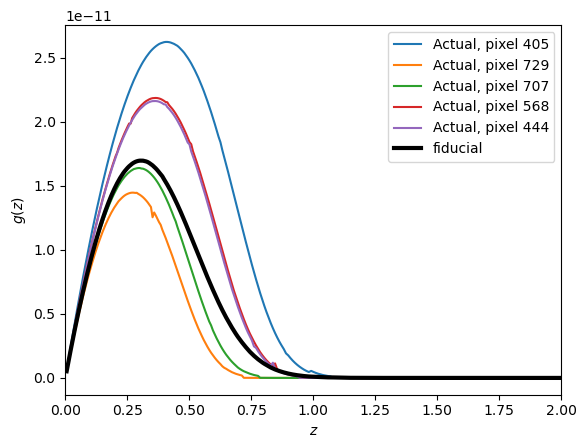

In [111]:
# Extract the perturbation
delta_g_maps = g_pert - g_fid

# Plot some typical realizations
for pixel_id in np.random.randint(0,npix,5):
    plt.plot(z_array[0,:], g_pert[pixel_id,:], label='Actual, pixel {}'.format(pixel_id))

# Plot the fiducial dndz
plt.plot(z_array[0,:], g_fid, color='k', lw=3, label='fiducial')

plt.ylabel(r'$g(z)$')
plt.xlabel(r'$z$')
plt.xlim([0,2])
plt.legend()

Text(0, 0.5, '$\\langle \\Delta g (z) \\rangle$')

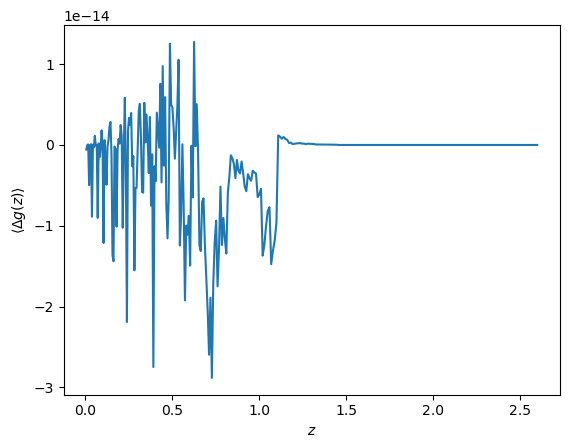

In [112]:
# Make sure that \delta g has no monopole
plt.plot(z_array[0,:], np.mean(delta_g_maps, axis=0))
plt.xlabel(r'$z$')
plt.ylabel(r'$\langle \Delta g (z) \rangle$')

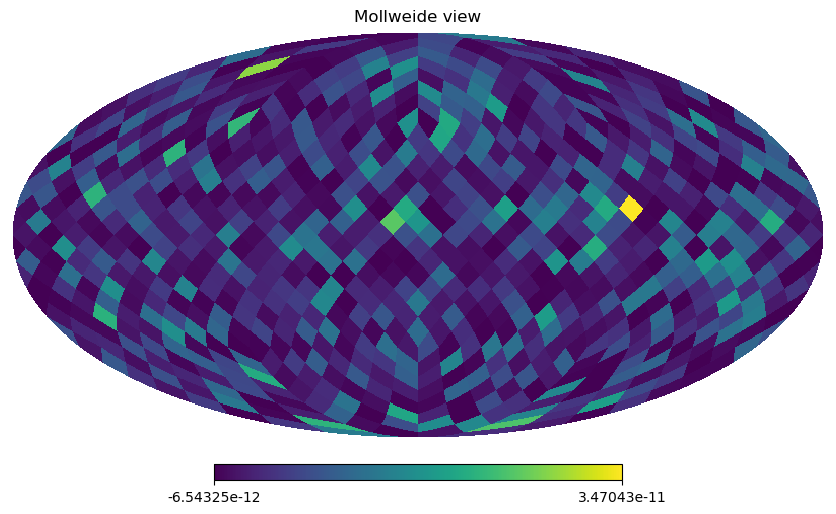

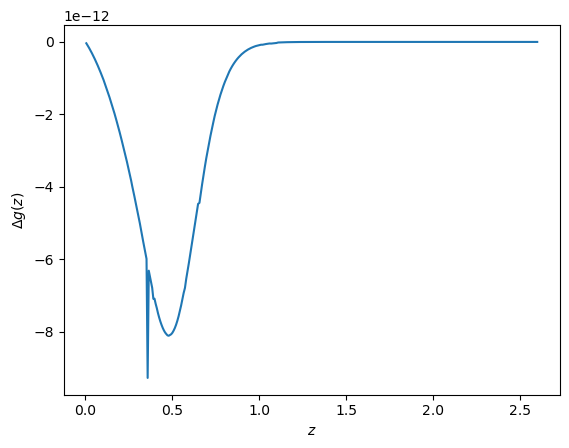

In [117]:
 # Plot a map of an chi-slice where we expect significant fluctuations
chi_mean_idx = np.where(chi_array>chi_mean_fid)[0][0]
hp.mollview(delta_g_maps[:,chi_mean_idx])
plt.show()

# Plot the Delta g (z) at a random pixel
pix_idx = np.random.randint(0, npix)
plt.plot(z_array[pix_idx,:], delta_g_maps[pix_idx,:])
plt.ylabel(r'$\Delta g(z)$')
plt.xlabel(r'$z$')
plt.show()

In [118]:
# Let us up-sample the maps
nside_out = 64 # If running on a laptop, don't go above nside_out=128 (nside_out = 256 already requires 20Gb of memory)

delta_g_maps_upsampled = np.zeros((hp.nside2npix(nside_out), n_samples_of_chi))
for i in range(len(chi_array)):
    delta_g_maps_upsampled[:,i] = hp.ud_grade(delta_g_maps[:,i], nside_out)
    
delta_g_maps = delta_g_maps_upsampled

In [119]:
# To avoid ringing due to the hard edges on which we seed the anisotropy, we smooth the maps with a Gaussian 
# with sigma equal to 1/2 of the typical width one of the big pixels (characterized by nside, not nside_out)
sigma_gaussian_smoothing = np.sqrt(4*np.pi/npix)/2. * (360*60/(2*np.pi)) # in arcmin

def bl(fwhm_arcmin, lmax):
    """ returns the map-level transfer function for a symmetric Gaussian beam.
         * fwhm_arcmin      = beam full-width-at-half-maximum (fwhm) in arcmin.
         * lmax             = maximum multipole.
    """
    ls = np.arange(0, lmax+1)
    return np.exp( -(fwhm_arcmin * np.pi/180./60.)**2 / (16.*np.log(2.)) * ls*(ls+1.) )

beam = bl(sigma_gaussian_smoothing, 3*nside_out-1)

In [120]:
# Take the spherical harmonic transform of each r slice. Conveniently, we can take complex SHT so array sizes reduce by x2
delta_g_lm_of_chi = np.zeros((hp.Alm.getsize(3*nside_out-1), n_samples_of_chi), dtype=complex)
for i in range(n_samples_of_chi):
    delta_g_lm_of_chi[:,i] = hp.map2alm(delta_g_maps[:,i])
    # Smooth the map to reduce ringing due to the hard edges of the big pixels
    delta_g_lm_of_chi[:,i] = hp.almxfl(delta_g_lm_of_chi[:,i], beam) 

In [121]:
lmax = hp.Alm.getlmax(delta_g_lm_of_chi.shape[0])
Cl_deltag_of_chi1_chi2 = np.zeros((lmax+1, n_samples_of_chi, n_samples_of_chi))
pixwinf = hp.pixwin(nside_out)[0:lmax+1] # Get the pixel window function for the up-sampled pixelization

for i in range(delta_g_lm_of_chi.shape[0]):
    if i % 1000 == 0:
        # Print progress
        print('Completed {}%'.format(round(100*i/delta_g_lm_of_chi.shape[0]), 3))
    l, m = hp.Alm.getlm(lmax, i) # Get the l corresponding to each value of m

    if m!=0:
        # Healpix indexes only m (not -m, since Ylm=Yl-m for a real field), so correct the sum for this
        factor = 2
    else:
        factor = 1

    # Get angular PS and deconvolve pixel window function for all possible combinations of chi1 and chi2 
    Cl_deltag_of_chi1_chi2[l,:,:] += factor*np.outer(delta_g_lm_of_chi[i,:], np.conj(delta_g_lm_of_chi[i,:])).real/ (2*l+1) / pixwinf[l]**2

Completed 0%
Completed 5%
Completed 11%
Completed 16%
Completed 22%
Completed 27%
Completed 32%
Completed 38%
Completed 43%
Completed 49%
Completed 54%
Completed 59%
Completed 65%
Completed 70%
Completed 76%
Completed 81%
Completed 86%
Completed 92%
Completed 97%


## Visualize $C_l^{\Delta g \Delta g}(\chi)$


(1.0, 5000.0)

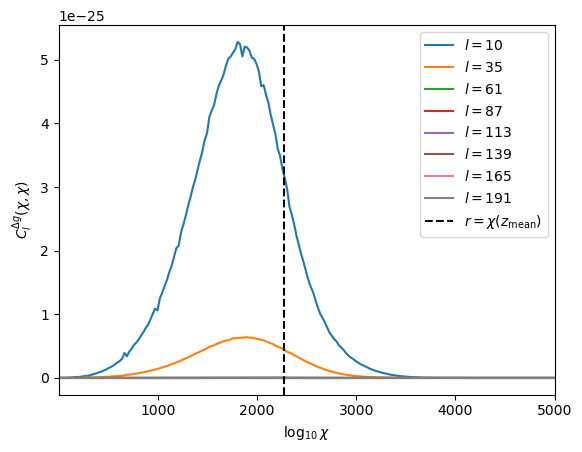

In [129]:
for l_to_plot in np.linspace(10,lmax,8, dtype=int):
    plt.plot(chi_array, np.diagonal(Cl_deltag_of_chi1_chi2, axis1=1, axis2=2)[l_to_plot,:], label=r'$l={}$'.format(l_to_plot))

plt.axvline(chi_mean_fid, ls='--', color='k', label=r'$r=\chi(z_{\mathrm{mean}})$')
plt.xlabel(r'$\mathrm{log}_{10}\,\chi$')
plt.ylabel(r'$C_l^{\Delta g}(\chi,\chi)$')
plt.legend()
plt.xlim([1,5000])

/var/folders/l0/bsqsn6_s01b0hvjnf7bv_wdw0000gn/T/ipykernel_94986/3724452684.py:2: RuntimeWarning: divide by zero encountered in log10
  Z = np.log10(np.diagonal(Cl_deltag_of_chi1_chi2, axis1=1, axis2=2))


(2.0, 252.0)

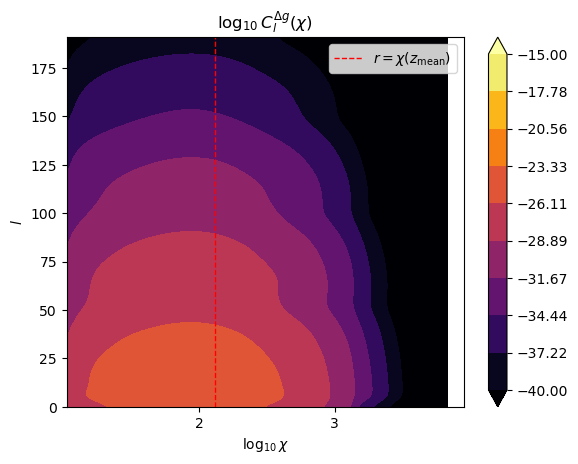

In [124]:
X, Y = np.meshgrid(np.arange(len(chi_array)), np.arange(lmax+1))
Z = np.log10(np.diagonal(Cl_deltag_of_chi1_chi2, axis1=1, axis2=2))

contours = np.linspace(-40,-15,10)

# Smooth array with a Gaussian filter for plotting purposes
Z_smoothed = gaussian_filter(Z, sigma=3)
plt.contourf(X, Y, Z_smoothed, levels=contours, cmap='inferno', extend='both')


ax = plt.gca()
ax.axvline(np.where(chi_array>chi_mean_fid)[0][0], color='r', ls='--', lw=1, label=r'$r=\chi(z_{\mathrm{mean}})$')
ax.set_ylim([0,lmax])

plt.xlabel(r'$\mathrm{log}_{10}\,\chi$')
plt.ylabel(r'$l$')

label_locs = np.arange(int(round(np.log10(np.min(chi_array)),0)), int(round(np.log10(np.max(chi_array)),0))+1, 1)
ax.set_xticks(np.linspace(0, len(chi_array), len(label_locs)))
ax.set_xticklabels(label_locs.astype('str'))
plt.legend()

plt.title(r'$\mathrm{log}_{10} \, C_l^{\Delta g}(\chi)$')
plt.colorbar(location='right')

plt.xlim([np.where(chi_array>50)[0][0], np.where(chi_array>6000)[0][0]])

## Visualize $C_l^{\Delta g \Delta g}(\chi_1,\chi_2)$



/var/folders/l0/bsqsn6_s01b0hvjnf7bv_wdw0000gn/T/ipykernel_94986/1105386925.py:3: RuntimeWarning: divide by zero encountered in log10
  Z_fixed_chi = np.log10(np.abs(Cl_deltag_of_chi1_chi2[:,:,chi_idx]))


(2.0, 252.0)

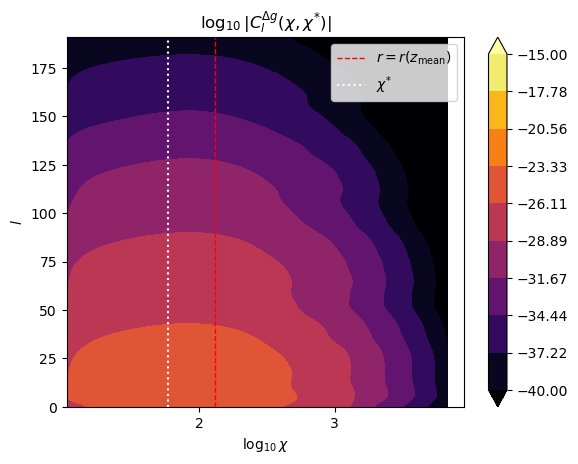

In [125]:
chi_idx = np.where(np.log10(chi_array)>3.2)[0][0]

Z_fixed_chi = np.log10(np.abs(Cl_deltag_of_chi1_chi2[:,:,chi_idx]))
# Smooth array with a Gaussian filter for plotting purposes
Z_fixed_chi_smoothed = gaussian_filter(Z_fixed_chi, sigma=3)

plt.contourf(X, Y, Z_fixed_chi_smoothed, levels=contours, cmap='inferno', extend='both')

plt.xlabel(r'$\mathrm{log}_{10}\,\chi$')
plt.ylabel(r'$l$')

ax = plt.gca()
ax.axvline(np.where(chi_array>chi_mean_fid)[0][0], color='r', ls='--', lw=1, label=r'$r=r(z_{\mathrm{mean}})$')

ax.set_ylim([0,lmax])

label_locs = np.arange(int(round(np.log10(np.min(chi_array)),0)), int(round(np.log10(np.max(chi_array)),0))+1, 1)
ax.set_xticks(np.linspace(0, len(chi_array), len(label_locs)))
ax.set_xticklabels(label_locs.astype('str'))

plt.title(r'$\mathrm{log}_{10} \, |C_l^{\Delta g}(\chi,\chi^{*})|$')
plt.colorbar(location='right')

ax.axvline(chi_idx, label=r'$\chi^{*}$', ls=':', color='w')
plt.legend()
plt.xlim([np.where(chi_array>50)[0][0], np.where(chi_array>6000)[0][0]])

# Non-linear matter PS

- Careful with factors of h!
- We have to evaluate matter PS at every chi, right?

Get the non-linear matter power spectrum at the central redshift of the unperturbed source gaalxy distribution. THIS IS PROBABLY INADEQUATE!!

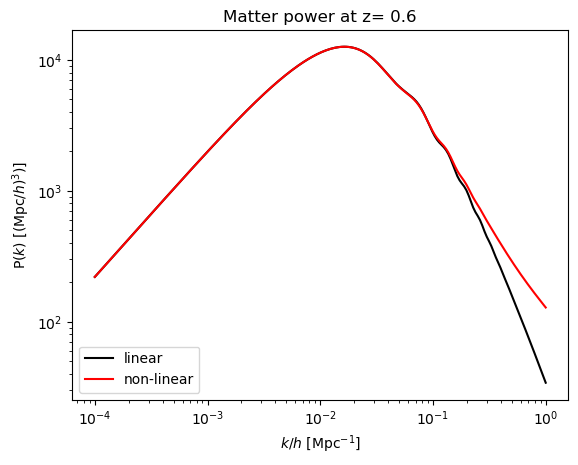

In [145]:
import camb
from camb import model

#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()
h = Planck18.H0.value/100.
pars.set_cosmology(H0=Planck18.H0.value, ombh2=Planck18.Ob0 * h**2, omch2=Planck18.Odm0 * h**2)
pars.InitPower.set_params(ns=0.965)
#Note non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[z_mean], kmax=2.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)

for i, (redshift, line) in enumerate(zip(z,['-','--'])):
    plt.loglog(kh, pk[i,:], color='k', ls = line)
    plt.loglog(kh_nonlin, pk_nonlin[i,:], color='r', ls = line)
plt.xlabel(r'$k/h$ [Mpc$^{-1}$]');
plt.ylabel(r'P($k$) [(Mpc/$h)^3)$]');
plt.legend(['linear','non-linear'], loc='lower left');
plt.title('Matter power at z= %s'%tuple(z));

In [149]:
# Remove factors of h
k_nonlin = kh_nonlin * h
pk_nonlin *= h**3

# Calculate biases

#### In the Limber approximation

To DO:
- Allow Pkmm to vary with redshift? 
- Choose lprime_max more systematically
- Parallelize! (should be rather trivial to do)

In [154]:
g_fid_interp = interp1d(chi_array, g_fid)
g_pert_interp = interp1d(chi_array, g_pert)

Calculate the convolutional bias term

In [161]:
def integrand_conv_term(chi, small_l, big_L, prefactor):
    '''
    Integrand for the convolutional bias term in the Limber approximation.
    Requires globally-defined Pkgg_interp(k) and cldp_interp(k)[l], interpolated in k
    '''
    return prefactor/ chi**2 * Pkmm_interp((big_L+0.5)/chi) * cldg_interp(chi)[small_l]

# Interpolate the spectra to be integrated over
cldg_interp = interp1d(chi_array, np.diagonal(Cl_deltag_of_chi1_chi2, axis1=1, axis2=2), axis=-1)
Pkmm_interp = interp1d(k_nonlin, pk_nonlin, bounds_error=False, fill_value='extrapolate')

lprime_max = 100 #Value of l above which we ignore the anisotropy in C_l^{\Delta \phi}(k)

conv_bias_ells = np.logspace(1.5, 3, 3, dtype=int)
conv_bias = np.zeros_like(conv_bias_ells, dtype=float)

for i, l in enumerate(conv_bias_ells):
    print('Working on l={}; iteration {}/{}'.format(l, i+1, len(conv_bias_ells)))
    for lprime in range(lprime_max):
        for L in np.arange(np.abs(l-lprime), np.abs(l+lprime)+1, 1):
            if (l+lprime+L)%2==0:
                w3 = wigner_3j(l, L, lprime, 0, 0, 0)
                prefactor = float(w3)**2 * (2*lprime+1) * (2*l+1) / (4*np.pi)
                integ, error = quadrature(integrand_conv_term,chi_min_int, chi_max_int, args=(lprime, L, prefactor), maxiter=1000, tol=1e-20)
                conv_bias[i] += integ

Working on l=31; iteration 1/3
Working on l=177; iteration 2/3
Working on l=1000; iteration 3/3


Get the unbiased Clkk for comparison -- for now, only auto of a given bin

In [168]:
def integrand_unbiased_auto_term(chi, small_l):
    '''
    Integrand for the unbiased Clkk auto spectrum in the Limber approximation.
    Requires globally-defined Pkmm_interp(k), interpolated in k and assumed to be z-idependent
    '''
    return Pkmm_interp((small_l+0.5)/chi) * (g_fid_interp(chi)/chi)**2

clkk_unbiased = np.zeros_like(conv_bias_ells, dtype=float)

for i, l in enumerate(conv_bias_ells):
    print('Working on l={}; iteration {}/{}'.format(l, i+1, len(conv_bias_ells)))
    clkk_unbiased[i], error = quadrature(integrand_unbiased_auto_term, chi_min_int, 
                                       chi_max_int, args=(l), maxiter=1000, tol=1e-15)

Working on l=31; iteration 1/3
Working on l=177; iteration 2/3
Working on l=1000; iteration 3/3


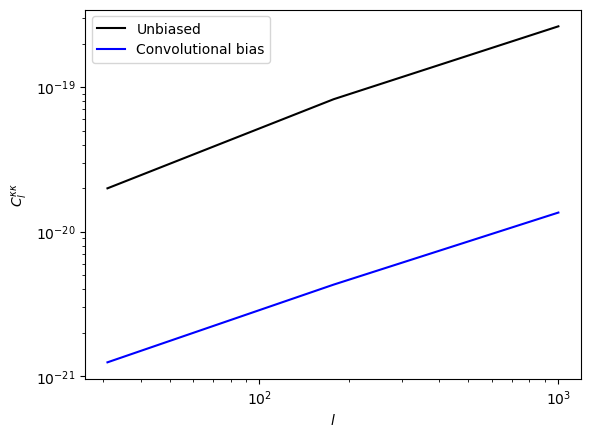

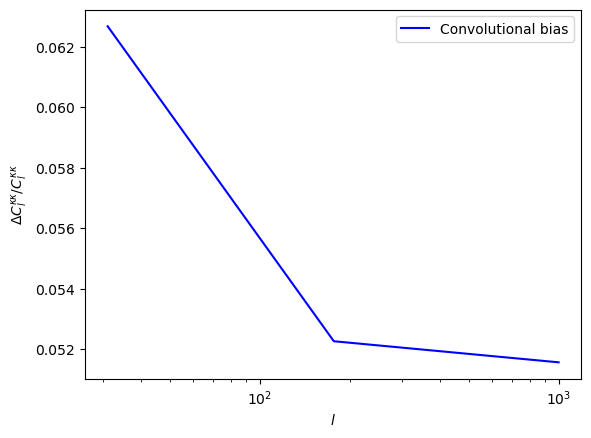

In [169]:
scaling = conv_bias_ells**2/(2*np.pi)
plt.loglog(conv_bias_ells, scaling * clkk_unbiased, 'k', label=r'Unbiased')
plt.loglog(conv_bias_ells, scaling * conv_bias, 'b', label=r'Convolutional bias')

plt.xlabel(r'$l$')
plt.ylabel(r'$C_l^{\kappa\kappa}$')
plt.legend()

plt.show()

plt.plot(conv_bias_ells, conv_bias/clkk_unbiased, 'b', label=r'Convolutional bias')

plt.xlabel(r'$l$')
plt.ylabel(r'$\Delta C_l^{\kappa\kappa} / C_l^{\kappa\kappa}$')
plt.legend()

plt.xscale('log')